In [2]:
import pandas as pd 
from pandas import MultiIndex, Int16Dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from IPython.display import display, Markdown
from scipy.stats import *

import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import KNNImputer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [3]:
df_raw = pd.read_pickle("./data/df_proper_cleaned.pkl")

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163955 entries, 0 to 167782
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                163955 non-null  int64  
 1   userId            163955 non-null  int64  
 2   gender            163955 non-null  object 
 3   sport             163955 non-null  object 
 4   heart_rate_mean   163955 non-null  float64
 5   heart_rate_std    163955 non-null  float64
 6   duration_s        163955 non-null  float64
 7   start_end         163955 non-null  object 
 8   altitude_mean     163955 non-null  float64
 9   altitude_std      163955 non-null  float64
 10  ascend_m          163955 non-null  float64
 11  descend_m         163955 non-null  float64
 12  distance_mean_m   163955 non-null  float64
 13  distance_std_m    163955 non-null  float64
 14  distance_total_m  163955 non-null  float64
 15  speed_mean        163955 non-null  float64
 16  speed_std         16

In [5]:
df_raw.sport.value_counts().index

Index(['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling',
       'walk', 'orienteering', 'cross-country skiing',
       'core stability training', 'fitness walking', 'skate', 'roller skiing',
       'hiking', 'circuit training', 'kayaking', 'rowing', 'weight training',
       'soccer', 'downhill skiing', 'gymnastics'],
      dtype='object')

# Modeling

In [6]:
class Transformer(object):
    def __init__(self, fillnan=True):
        self._NAME_ = 'Transformer'
        
        # categorical features to dummify and then drop
        self.feature_categorical = ['userId', 'gender','sport']
        
        # numeric features to keep
        self.feature_numeric = ['heart_rate_mean', 'heart_rate_std', 
                                   'altitude_mean', 'altitude_std',
                                   'ascend_m', 'descend_m', 'distance_total_m',
                                   'speed_mean','speed_std','duration_s','calories']
        
        # from the top 20 sport list
        self.sports = ['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling',
                       'walk', 'orienteering', 'cross-country skiing',
                       'core stability training', 'fitness walking', 'skate', 'roller skiing',
                       'hiking', 'circuit training', 'kayaking', 'rowing', 'weight training',
                       'soccer', 'downhill skiing', 'gymnastics']
        
        self.gender = ['male','female','unknown']
        
        self.FILLNAN = fillnan
        
    def fit(self, X, y=None):
        if self.FILLNAN:
            col_list = list(set(X.columns) & set(self.feature_numeric))
            self.mean = X[col_list].mean()
        
    def transform(self, X, y=None):
        features = X.columns
        df = pd.DataFrame()
        for feature in features:
            if feature =='start_time':
                date = pd.to_datetime(X[feature])
                df['year'] = date.dt.year
                df['month'] = date.dt.month
                df['weekday'] = date.dt.weekday
            if feature =='gender':
                for g in self.gender:
                    df[g] = (X[feature]==g).astype(int)
                    
            if feature == 'sport': # dummy transform onto fixed categorical labels
                for s in self.sports:
                    df[s] = (X[feature]==s).astype(int)
            
            if feature in self.feature_numeric:
                df[feature] = X[feature]
        
        if hasattr(self, 'mean') and self.FILLNAN:
            df = df.fillna(self.mean)
            
        # engineering new features
        #if {'calories', 'duration_s'}.issubset(df.columns):
        #    df['calories_rate'] = (1000*df['calories'])/df['duration_s']
        
        return df
        
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
        
df_transformed = Transformer(fillnan=True).fit_transform(df_raw)
print(df_transformed.info())
df_transformed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163955 entries, 0 to 167782
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   male                     163955 non-null  int64  
 1   female                   163955 non-null  int64  
 2   unknown                  163955 non-null  int64  
 3   bike                     163955 non-null  int64  
 4   run                      163955 non-null  int64  
 5   mountain bike            163955 non-null  int64  
 6   bike (transport)         163955 non-null  int64  
 7   indoor cycling           163955 non-null  int64  
 8   walk                     163955 non-null  int64  
 9   orienteering             163955 non-null  int64  
 10  cross-country skiing     163955 non-null  int64  
 11  core stability training  163955 non-null  int64  
 12  fitness walking          163955 non-null  int64  
 13  skate                    163955 non-null  int64  
 14  roll

,male,female,unknown,bike,run,mountain bike,bike (transport),indoor cycling,walk,orienteering,...,altitude_std,ascend_m,descend_m,distance_total_m,speed_mean,speed_std,calories,year,month,weekday
0,1,0,0,1,0,0,0,0,0,0,...,13.475900,407.6,413.0,53049.413644,7.117435,2.182678,1563.0,2014,8,6
1,1,0,0,1,0,0,0,0,0,0,...,10.376062,225.4,228.8,32467.566953,7.550103,2.272863,909.0,2014,8,5
2,1,0,0,1,0,0,0,0,0,0,...,13.217515,328.8,352.4,45309.570377,7.154326,2.150951,1139.0,2014,8,1
3,1,0,0,1,0,0,0,0,0,0,...,11.417463,242.8,238.6,32529.910062,7.416873,2.201268,922.0,2014,8,3
4,1,0,0,0,0,0,1,0,0,0,...,8.383674,89.6,107.4,11936.117059,8.721936,2.388718,351.0,2014,8,4


## Split train, test

In [7]:
# features to be scaled within individual user
'''
feature_user = ['heart_rate_mean','speed_mean','calories']
userId = df.userId.value_counts().index
for user in userId:
    index = df_raw.userId==user
    temp = df_raw[index]
    for feature in feature_user:
        mean = np.nanmean(temp[feature])
        std = np.nanstd(temp[feature])
        #print(mean,std)
        df_raw.loc[index, feature] = (temp[feature].values - mean)/std 
'''

"\nfeature_user = ['heart_rate_mean','speed_mean','calories']\nuserId = df.userId.value_counts().index\nfor user in userId:\n    index = df_raw.userId==user\n    temp = df_raw[index]\n    for feature in feature_user:\n        mean = np.nanmean(temp[feature])\n        std = np.nanstd(temp[feature])\n        #print(mean,std)\n        df_raw.loc[index, feature] = (temp[feature].values - mean)/std \n"

In [8]:
train_raw, test_raw = train_test_split(df_raw.reset_index(drop=True), test_size=0.1, random_state=42)
print(df_raw.shape, train_raw.shape, test_raw.shape)

(163955, 21) (147559, 21) (16396, 21)


## A linear regression model with Ridge regularization

In [9]:
target = 'heart_rate_mean'
features = ['sport', 'gender', 'heart_rate_mean', 'heart_rate_std', 'altitude_mean',
           'altitude_std', 'ascend_m', 'descend_m', 'distance_total_m',
           'speed_mean', 'speed_std', 'duration_s', 'calories', 'start_time']

features.remove(target)

steps = [('transformer', Transformer()),
         ('poly', PolynomialFeatures()),
         ('rescale',RobustScaler()), 
         #('pca', PCA()),
         ('lr', Ridge())]

model = Pipeline(steps)

param_grid = {'poly__degree': [2], # 2 
              #'pca__n_components': [20], 
              'lr__alpha': [1], #1
              }

search = GridSearchCV(estimator = model, 
                      param_grid = param_grid, 
                      scoring= 'neg_mean_squared_error', 
                      cv = 5, n_jobs = -1, 
                      verbose=1, error_score = 'raise')

search.fit(train_raw[features], train_raw[target])
print(f'Best={search.best_params_}, Best score = {search.best_score_: .2e}')

y_train_pred_lr = search.predict(train_raw[features])
y_test_pred_lr = search.predict(test_raw[features])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best={'lr__alpha': 1, 'poly__degree': 2}, Best score = -2.39e+02


In [10]:
#from sklearn.inspection import permutation_importance
#r = permutation_importance(search.best_estimator_['lr'], train_raw[features], test_raw[features],
#                            n_repeats=30, random_state=0)

In [11]:
search.best_estimator_['lr'].coef_.shape

(703,)

======== Linear Regression with Ridge ===========
Best={'lr__alpha': 1, 'poly__degree': 2}, Best score = -2.39e+02
mean_absolute_error on Train set =  9.60e+00
mean_absolute_error on  Test set =  9.66e+00
mean_squared_error on Train set =  1.53e+02
mean_squared_error on  Test set =  1.59e+02
r2_score on Train set =  4.80e-01
r2_score on  Test set =  4.62e-01
======== Linear Regression ===========
MAE =  9.60e+00       
MSE =  1.59e+02, 
R2 =  0.462


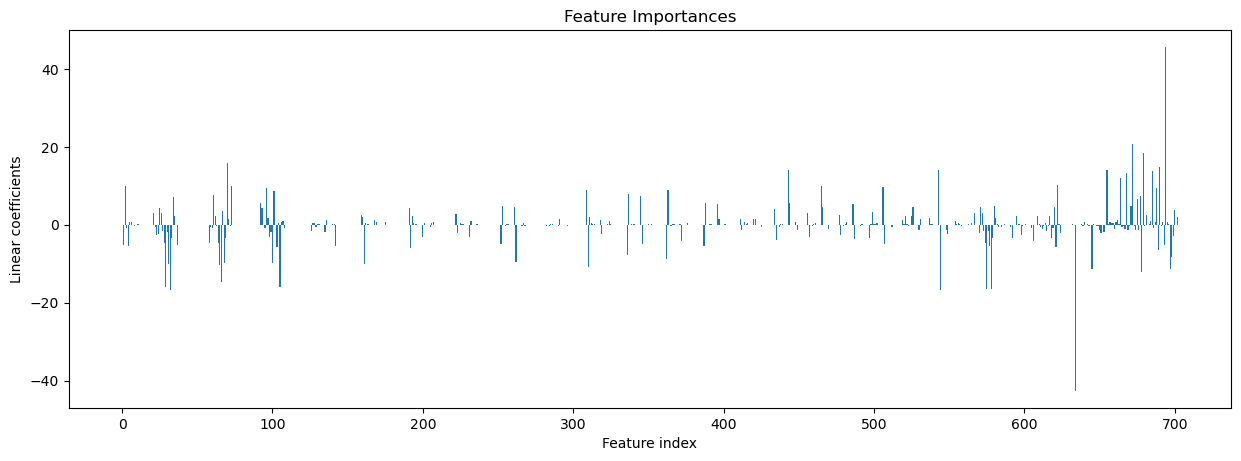

In [12]:
print('======== Linear Regression with Ridge ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_: .2e}')
all_metrics = [mean_absolute_error, mean_squared_error, r2_score]
for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_lr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_lr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_lr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== Linear Regression ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_lr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_lr): .2e}, \nR2 = {R2: .3f}")

plt.figure(figsize=(15,5), dpi =100)
plt.bar(np.arange(len(search.best_estimator_['lr'].coef_)),  search.best_estimator_['lr'].coef_)
plt.title('Feature Importances'), plt.xlabel('Feature index'), plt.ylabel('Linear coefficients');

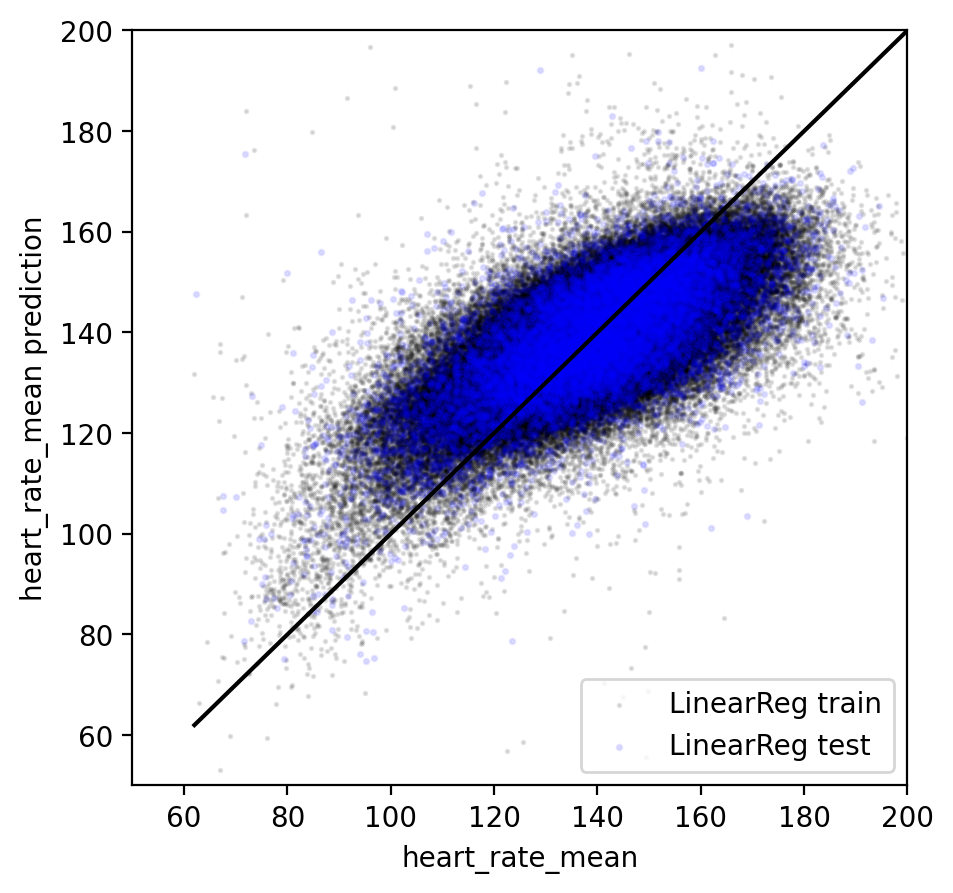

In [13]:
plt.figure(figsize=(5,5),dpi=200)
plt.scatter(train_raw[target], y_train_pred_lr, c = 'k', s = 1, alpha = 0.1, label ='LinearReg train')
plt.scatter(test_raw[target], y_test_pred_lr, c = 'b', s = 3, alpha = 0.1, label ='LinearReg test')

plt.plot([train_raw[target].min(),train_raw[target].max()], 
        [train_raw[target].min(),train_raw[target].max()], color = 'k', label = '' )
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
#plt.xscale('log'), plt.yscale('log')
plt.xlim(50,200),plt.ylim(50,200)
plt.legend();

# Xgboost

In [14]:
from xgboost import XGBRegressor
steps = [('transformer', Transformer()), 
         ('xgbr', XGBRegressor())]

model = Pipeline(steps)
param_grid = {'xgbr__n_estimators': [150], #150
              'xgbr__learning_rate':[0.15], #0.15
              'xgbr__max_depth':[3], # 3
              'xgbr__lambda':[2], 
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid, 
                      cv =  5, n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      verbose=1, error_score = 'raise')

search.fit(train_raw[features], train_raw[target])
print(f'Best={search.best_params_}, Best score = {search.best_score_}')

y_train_pred_xgbr = search.predict(train_raw[features])
y_test_pred_xgbr = search.predict(test_raw[features])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best={'xgbr__lambda': 2, 'xgbr__learning_rate': 0.15, 'xgbr__max_depth': 3, 'xgbr__n_estimators': 150}, Best score = -137.66411136343316


======== XGBR ===========
Best={'xgbr__lambda': 2, 'xgbr__learning_rate': 0.15, 'xgbr__max_depth': 3, 'xgbr__n_estimators': 150}, Best score = -137.66411136343316
mean_absolute_error on Train set =  9.00e+00
mean_absolute_error on  Test set =  9.09e+00
mean_squared_error on Train set =  1.35e+02
mean_squared_error on  Test set =  1.38e+02
r2_score on Train set =  5.43e-01
r2_score on  Test set =  5.35e-01
======== XGBR ===========
MAE =  9.00e+00       
MSE =  1.38e+02, 
R2 =  0.535


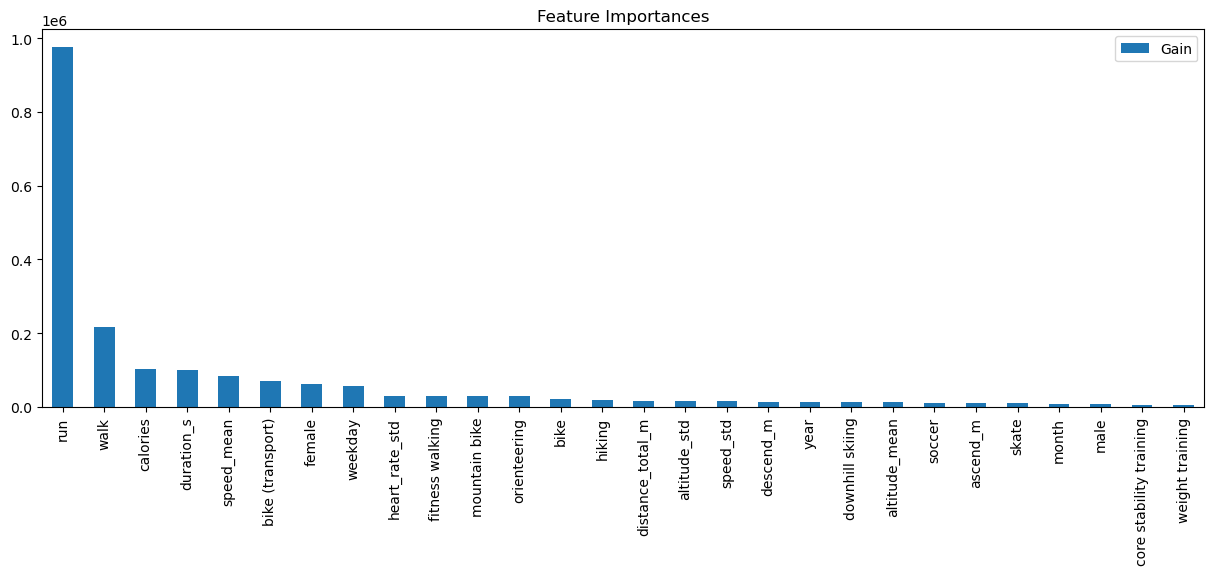

In [15]:
print('======== XGBR ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_}')

for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_xgbr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_xgbr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_xgbr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== XGBR ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_xgbr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_xgbr): .2e}, \nR2 = {R2: .3f}")

feature_importances = pd.DataFrame.from_dict(search.best_estimator_['xgbr'].
                                             get_booster().get_score(importance_type="gain"),
                                             orient='index').rename(columns={0:'Gain'})
fig = plt.figure(figsize=(15,5), dpi=100)
feature_importances.sort_values(by=['Gain'],ascending = False).plot(kind='bar', title='Feature Importances', ax = plt.gca());

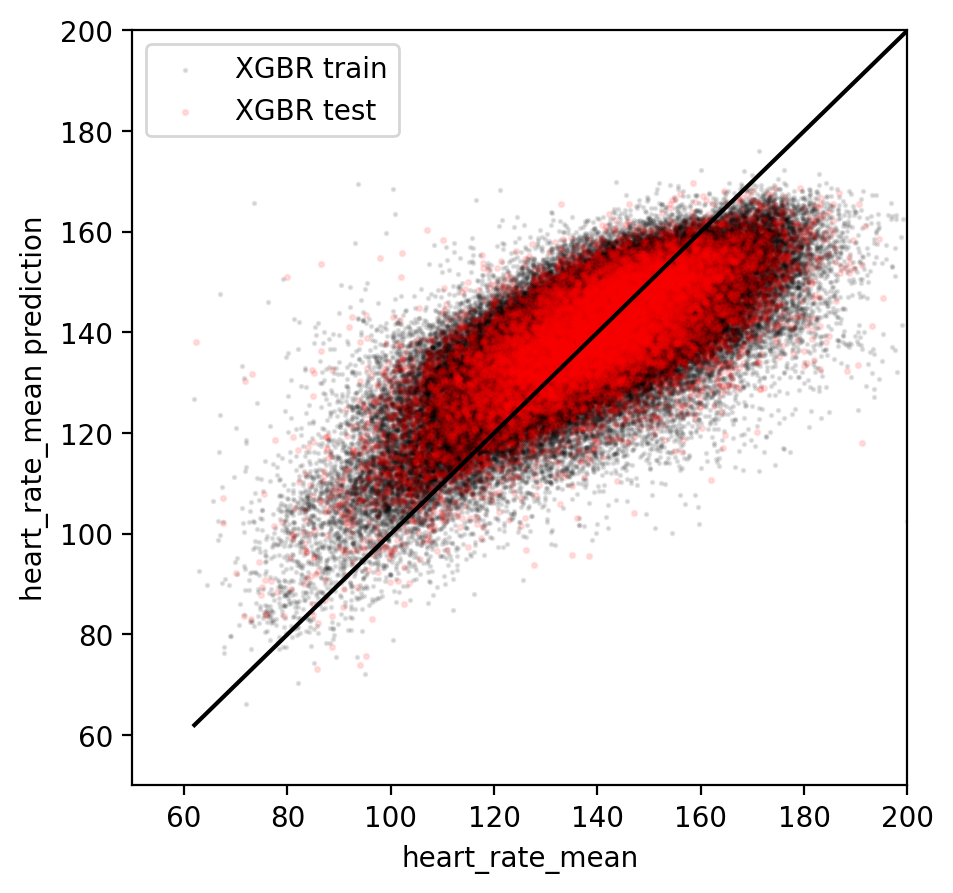

In [16]:
plt.figure(figsize=(5,5),dpi=200)
plt.scatter(train_raw[target], y_train_pred_xgbr, c = 'k', s = 1, alpha = 0.1, label ='XGBR train')
plt.scatter(test_raw[target], y_test_pred_xgbr, c = 'r', s = 3, alpha = 0.1, label ='XGBR test')

plt.plot([train_raw[target].min(),train_raw[target].max()], 
        [train_raw[target].min(),train_raw[target].max()], color = 'k', label = '' )
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
#plt.xscale('log'), plt.yscale('log')
plt.xlim(50,200),plt.ylim(50,200)
plt.legend();

# Random Forest

In [17]:
steps = [('transformer', Transformer()), 
         ('rfr', RandomForestRegressor())]

model = Pipeline(steps)
param_grid = {'rfr__n_estimators': [150], #150
              'rfr__max_depth':[10], # 3
              'rfr__min_samples_split':[10], 
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid, 
                      cv =  5, n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      verbose=1, error_score = 'raise')
search.fit(train_raw[features], train_raw[target])
print(f'Best={search.best_params_}, Best score = {search.best_score_}')

y_train_pred_rfr = search.predict(train_raw[features])
y_test_pred_rfr = search.predict(test_raw[features])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best={'rfr__max_depth': 10, 'rfr__min_samples_split': 10, 'rfr__n_estimators': 150}, Best score = -137.1831610198414


======== Random Forest ===========
Best={'rfr__max_depth': 10, 'rfr__min_samples_split': 10, 'rfr__n_estimators': 150}, Best score = -137.1831610198414
mean_absolute_error on Train set =  8.68e+00
mean_absolute_error on  Test set =  9.04e+00
mean_squared_error on Train set =  1.26e+02
mean_squared_error on  Test set =  1.37e+02
r2_score on Train set =  5.72e-01
r2_score on  Test set =  5.36e-01
======== Random Forest ===========
MAE =  8.68e+00       
MSE =  1.37e+02, 
R2 =  0.536


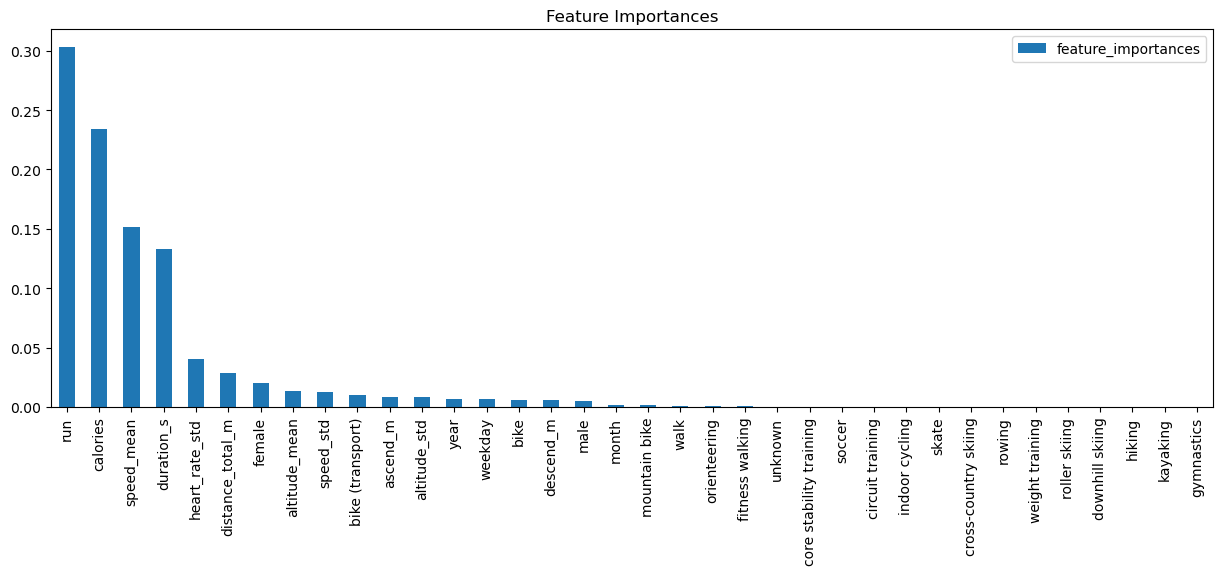

In [18]:
print('======== Random Forest ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_}')
all_metrics = [mean_absolute_error, mean_squared_error, r2_score]

for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_rfr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_rfr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_rfr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== Random Forest ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_rfr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_rfr): .2e}, \nR2 = {R2: .3f}")

feature_importances = pd.DataFrame(data=search.best_estimator_['rfr'].feature_importances_,
                                  index=search.best_estimator_['rfr'].feature_names_in_,
                                  columns=['feature_importances'])

fig = plt.figure(figsize=(15,5), dpi=100)
feature_importances.sort_values(by=['feature_importances'], ascending=False).plot(kind='bar', title='Feature Importances', ax = plt.gca());

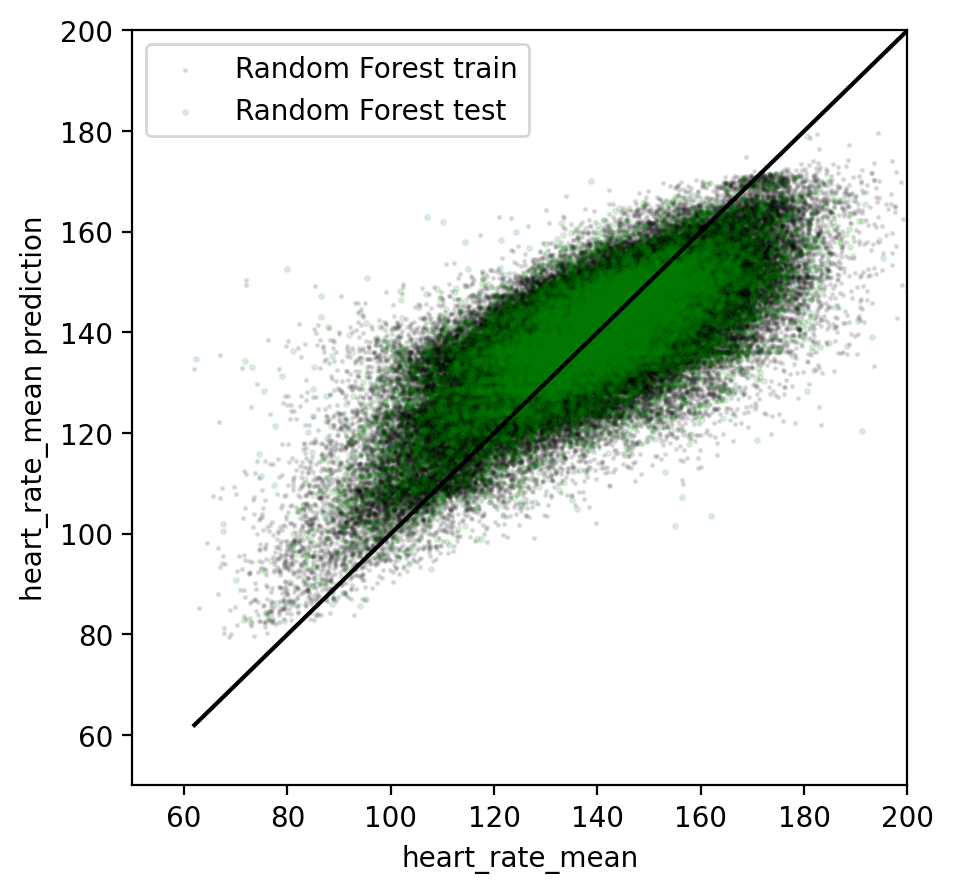

In [19]:
plt.figure(figsize=(5,5),dpi=200)
plt.plot([train_raw[target].min(),train_raw[target].max()],
         [train_raw[target].min(),train_raw[target].max()], color = 'k', label = '')
plt.scatter(train_raw[target], y_train_pred_rfr, c = 'k', s = 1, alpha = 0.1, label ='Random Forest train')
plt.scatter(test_raw[target], y_test_pred_rfr, c = 'g', s = 3, alpha = 0.1, label ='Random Forest test')
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
#plt.xscale('log'), plt.yscale('log')
plt.xlim(50,200),plt.ylim(50,200)
plt.legend();